# Intent inference

 author: Steeve Laquitaine

 TABLE OF CONTENTS

 * Packages
 * Paths
 * Parameters
 * Load data
 * Filtering
   * by query complexity
   * by grammatical mood
   * by syntactical similarity
 * Parsing
 * Inference

 Observations:

   * So far the best parameters are:

       SEED            = " VB NP" <br>
       THRES_NUM_SENT  = 1 <br>
       NUM_SENT        = 1 <br>
       THRES_SIM_SCORE = 1 <br>
       FILT_MOOD       = ("ask",) <br>

# PACKAGES

In [1]:
import os
from collections import defaultdict

import pandas as pd
import spacy


In [2]:
proj_path = "/Users/steeve_laquitaine/desktop/CodeHub/intent/"
os.chdir(proj_path)
from intent.src.intent.nodes import (
    features,
    inference,
    parsing,
    preprocess,
    retrieval,
    similarity,
)
from intent.src.tests import test_run

todf = pd.DataFrame

Warming up PyWSD (takes ~10 secs)... took 6.740746021270752 secs.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/steeve_laquitaine/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/steeve_laquitaine/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# PATHS

In [3]:
cfg_path = (
    proj_path + "intent/data/02_intermediate/cfg_25_02_2021_18_16_42.xlsx"
)
sim_path = proj_path + "intent/data/02_intermediate/sim_matrix.xlsx"

# PARAMETERS

In [4]:
SEED = " VB NP"  # seed for comparison
THRES_NUM_SENT = 1  # keep query with max one sentence
NUM_SENT = 1  # keep query with max one sentence
THRES_SIM_SCORE = 1  # Keep queries syntactically similar to seed
FILT_MOOD = ("ask",)  # ("state", "wish-or-excl", "ask")  # Keep statements
DIST_THRES = 1.8  # inference threshold for clustering

 LOAD DATA

In [5]:
cfg = pd.read_excel(cfg_path)
sim_matx = pd.read_excel(sim_path)
# test
test_run.test_len_similarity_matx(cfg, sim_matx)


# FILTERING

## by query complexity

In [6]:
# cfg_cx = preprocess.filter_by_sent_count(cfg, THRES_NUM_SENT, verbose=True)
cfg_cx = preprocess.filter_n_sent_eq(cfg, NUM_SENT, verbose=True)

There are 100 original queries.
84 after filtering = 1 sentence queries.


## by grammatical mood

In [7]:
cfg_mood = preprocess.filter_in_only_mood(cfg_cx, FILT_MOOD)

In [8]:
tag = parsing.from_cfg_to_constituents(cfg_mood["cfg"])

## by syntactical similarity

In [9]:
posting_list = retrieval.create_posting_list(tag)
sim_ranked = similarity.rank_nearest_to_seed(sim_matx, seed=SEED, verbose=True)
ranked = similarity.print_ranked_VPs(cfg_mood, posting_list, sim_ranked)
filtered = similarity.filter_by_similarity(ranked, THRES_SIM_SCORE)
# test [TODO]
test_run.test_rank_nearest_to_seed(sim_matx, seed=SEED)
test_run.test_posting_list(posting_list, sim_matx, seed=SEED)
test_run.test_get_posting_index(cfg_mood, posting_list, sim_ranked)

0 duplicated syntaxes were dropped.
9 querie(s) is(are) left after filtering.


# PARSING

 * Apply dependency parsing to each query
 * Collect intent's action (ROOT) and object (dobj)

In [10]:
intents = parsing.parse_intent(filtered)

In [11]:
## OUTPUT

In [12]:
# set display options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", -1)
cfg_mood.merge(
    todf(intents, index=filtered.index), left_index=True, right_index=True
)[["text", "intent", "intendeed"]]

,text,intent,intendeed
0,How do I track the card you sent me?,[track],"[card, me]"
1,Can I track the card you sent to me?,[track],[card]
7,How can I periodically check the delivery of the card you sent?,[check],[delivery]
9,Could I get tracking on the card?,[get],[tracking]
10,Can I track the card that was just sent to me?,[track],[card]
29,Can I track the card that you sent me in the mail?,[track],"[card, me]"
30,When will I recieve my new card?,[recieve],[card]
59,Do you have info about the card on delivery?,[have],[info]
61,can you share card tracking number?,[number],NaN


# PREPROCESSINg

 Filter out words not contained in Wordnet

In [13]:
filtered_corpus = preprocess.filter_words_not_in_wordnet(tuple(cfg_mood["VP"]))

# INFERENCE

74.21 secs


,query,label
0,track card sent me,23
1,track card sent me,23
2,is expected delivery date card,30
3,is new card,27
4,do I still have not received new card,44
5,tell me why I have received new card,34
6,have not received card,46
7,check delivery card sent,20
8,have received it yet,5
9,get tracking on card,33


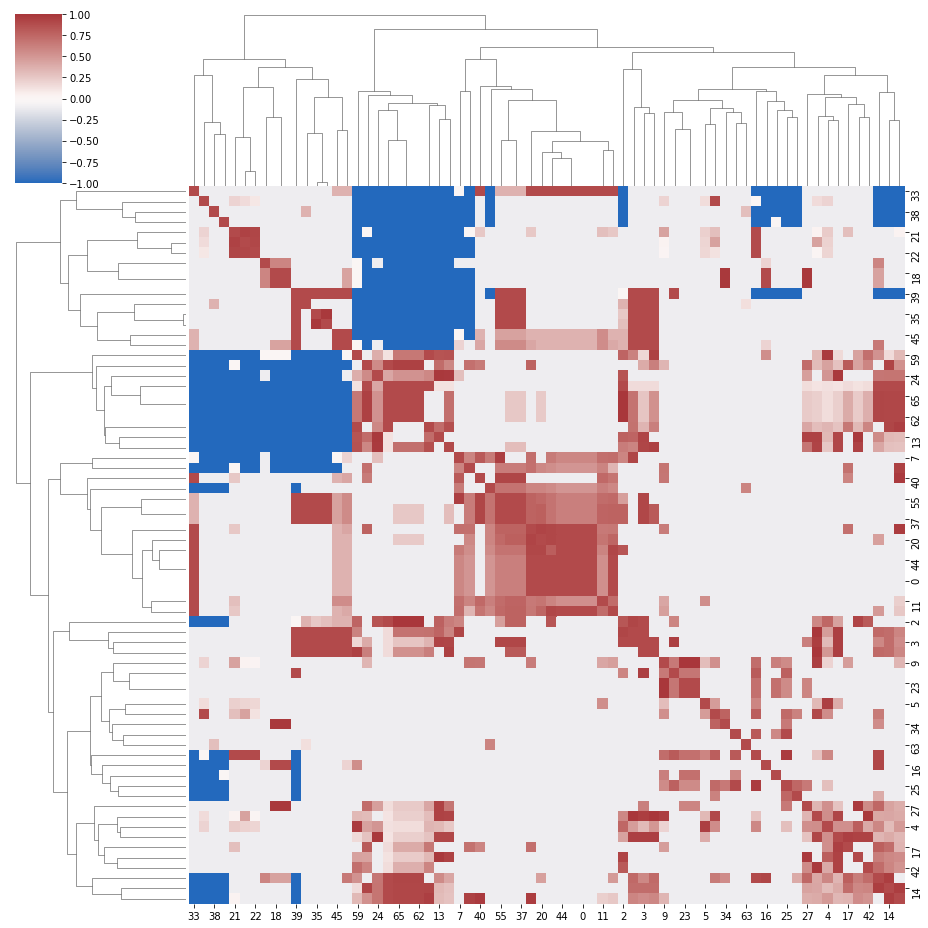

In [14]:
# [TODO]: debug: exception handling
labels = inference.label_queries(filtered_corpus, DIST_THRES)
labels



In [15]:
len(labels)

70

In [16]:
len(cfg_mood)

70